<a href="https://colab.research.google.com/github/plushvoxel/Project-Lernende-Agenten-colab/blob/master/RadioSignalClassifiziererWithAverageThingy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function

import math
from urllib import request
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from google.colab import files
from tarfile import open as taropen
from struct import unpack
import os
import glob
import math
import seaborn as sns
import time
!pip install XlsxWriter


    100% |████████████████████████████████| 143kB 6.6MB/s 


In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

request.urlretrieve("https://github.com/plushvoxel/Project-Lernende-Agenten-Data-Generator/blob/master/frequency.tar?raw=true", "frequency.tar")
tar = taropen("frequency.tar")

data = dict()
MODKEY = "mod"

for member in tar.getmembers():
  modulation = member.name.split('_')[0]
  if modulation == "am":
    modulation = 0
  else:
    modulation = 1
  if not MODKEY in data:
    data[MODKEY] = [modulation]
  else:
    data[MODKEY].append(modulation)
  with tar.extractfile(member) as f:
    buffer = f.read()
    num_floats = len(buffer)//4
    floats = unpack("f"*num_floats, buffer)
    i = floats[0::2]
    q = floats[1::2]
    for j in range(len(i)):
      ikey = "i{:05d}".format(j)
      qkey = "q{:05d}".format(j)
      if not ikey in data:
        data[ikey] = [i[j]]
      else:
        data[ikey].append(i[j])
      if not qkey in data:
        data[qkey] = [q[j]]
      else:
        data[qkey].append(q[j])        
signal_dataframe = pd.DataFrame(data=data)
signal_dataframeReal = signal_dataframe.copy()
signal_dataframe = signal_dataframe.reindex(np.random.permutation(signal_dataframe.index))
print(signal_dataframe)



      i00000  i00001  i00002  i00003  i00004  i00005  i00006  i00007  i00008  \
1176    -0.1     0.2    -0.2     0.1    -0.0     0.1    -0.2     0.2    -0.2   
553   -257.7   168.4    -3.1  -115.1   134.8   -79.8    62.9   -92.4    79.8   
196    303.7  -206.2    59.6    -5.1     0.2    -0.1     0.2    -0.7     6.9   
1285     0.2    -0.0     0.0    -0.1     0.2    -0.2     0.2    -0.4     0.4   
17       0.1    -0.2     0.2     0.0    -0.1    -0.1     0.2    -0.2     0.1   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1823    -0.2     0.2    -0.4     0.6    -0.9     1.1    -0.9     0.7    -0.5   
858   -170.3   438.5  -372.2   147.4   -21.2   -44.2    80.3   -70.1    49.3   
1838     0.8    -0.7     0.2     0.2    -0.5     0.7    -0.4     0.0     0.2   
681    -30.2     7.9    37.0   -57.6    22.2    38.0   -61.0    26.5    23.3   
1511     0.2    -0.3     0.5    -1.1     1.5    -1.0     0.2     0.1    -0.1   

      i00009   ...    q02038  q02039  q

In [0]:
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[MODKEY]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.iloc[:,1:4097]
  return labels, features

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  
  # There are 784 pixels in each image.
  return set([tf.feature_column.numeric_column('features', shape=4096)])

In [0]:
def create_predict_input_fn(features, labels, batch_size, repeat_count = 1):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"features": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(repeat_count)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True, repeat_count=1):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"features":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(repeat_count)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
def prepareWorksheet(worksheet):
  worksheet.write(0,0, 'Model')
  worksheet.write(0,1, 'learning rate')
  worksheet.write(0,2, 'training set size')
  worksheet.write(0,3, 'validating set size')
  worksheet.write(0,4, 'batchsize')
  worksheet.write(0,5, 'accuracy')
  worksheet.write(0,6, 'validation1')
  worksheet.write(0,7, 'validation2')
  worksheet.write(0,8, 'validation3')
  worksheet.write(0,9, 'validation4')
  worksheet.write(0,10, 'validation5')
  worksheet.write(0,11, 'validation6')
  worksheet.write(0,12, 'validation7')
  worksheet.write(0,13, 'validation8')
  worksheet.write(0,14, 'validation9')
  worksheet.write(0,15, 'validation10')
  worksheet.write(0,16, 'training1')
  worksheet.write(0,17, 'training2')
  worksheet.write(0,18, 'training3')
  worksheet.write(0,19, 'training4')
  worksheet.write(0,20, 'training5')
  worksheet.write(0,21, 'training6')
  worksheet.write(0,22, 'training7')
  worksheet.write(0,23, 'training8')
  worksheet.write(0,24, 'training9')
  worksheet.write(0,25, 'training10')
  

In [0]:
def insertIntoWorksheet(worksheet, line,hidden_units, learning_rate, training_examples_size,validating_examples_size, batch_size , accuracy):
  worksheet.write(line,0, hidden_units)
  worksheet.write(line,1, learning_rate)
  worksheet.write(line,2, training_examples_size)
  worksheet.write(line,3, validating_examples_size)
  worksheet.write(line,4, batch_size) 
  worksheet.write(line,5, accuracy)


In [0]:
def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    test_examples,
    test_targets,
    worksheet,
    line):
  """Trains a neural network classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, as well as a confusion
  matrix.
  
  Args:
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `DNNClassifier` object.
  """

  periods = 10
  # Caution: input pipelines are reset with each call to train. 
  # If the number of steps is small, your model may never see most of the data.  
  # So with multiple `.train` calls like this you may want to control the length 
  # of training with num_epochs passed to the input_fn. Or, you can do a really-big shuffle, 
  # or since it's in-memory data, shuffle all the data in the `input_fn`.
  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column('features', shape=4096)]

  # Create a DNNClassifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      n_classes=2,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1,
                                        model_dir="models")
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,2)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,2)
    
    test_predictions = list(classifier.predict(input_fn=predict_test_input_fn))
    test_probabilities = np.array([item['probabilities'] for item in test_predictions])    
    test_pred_class_id = np.array([item['class_ids'][0] for item in test_predictions])
    test_pred_one_hot = tf.keras.utils.to_categorical(test_pred_class_id,2)   
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    worksheet.write(line,(6+period), validation_log_loss)
    worksheet.write(line,(16+period),training_log_loss)
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_test_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(test_targets, final_predictions)
  print("Final accuracy (validation data): %0.2f" % accuracy)
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  pic1 = "{}.png".format(line)
  plt.savefig(pic1)
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(test_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()
  #pic2 = "plt2.png"
  #plt.savefig(pic2)
  model = "[input: 4096, "+str(hidden_units).strip('[]')+", output 2]"
  insertIntoWorksheet(worksheet, line, model, learning_rate, training_examples.shape[0],validation_examples.shape[0], batch_size , accuracy)
  print(model)
  print(learning_rate)
  print(training_examples.shape[0])
  print(validation_examples.shape[0])
  print(batch_size)
  print(accuracy)
  plt.close(pic1)
  #plt.close(pic2)
  return classifier, accuracy

In [0]:
def train_automated(
    training_set_size,
    validating_set_size,
    test_set_size,
    learning_rate,
    steps,
    batch_size,
    model,
    worksheet,
    line):
  """ Function used for automate the process of trying new network configurations
  
  Args:
    training_set_size: An 'int', number of samples used for training
    validating_set_size: An 'int', number of samples used for validation
    test_set_size: An 'int', number of samples used for test
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    model: A list of 'int', define the number of neurons in each hidden layer
      
  Returns:
    The trained `DNNClassifier` object.
  """
  activation_function = "RELU" #@param ["RELU", "Sigmoid", "Tanh"]
  regression = "None" #@param ["None", "L1", "L2"]
  regression_rate = 3 #@param ["3", "1", "0.3", "0.1", "0.03", "0.01", "0.003", "0.001"] {type:"raw"}
  training_targets, training_examples = parse_labels_and_features(signal_dataframe[0:training_set_size])
  validation_targets, validation_examples = parse_labels_and_features(signal_dataframe[training_set_size:(training_set_size+validating_set_size)])
  test_targets, test_examples = parse_labels_and_features(signal_dataframe[(training_set_size+validating_set_size):(training_set_size+validating_set_size+test_set_size)])
  nn_classification, accuracy = train_nn_classification_model(
      learning_rate=learning_rate,
      steps=steps,
      batch_size=batch_size,
      hidden_units=model,
      training_examples=training_examples,
      training_targets=training_targets,
      validation_examples=validation_examples,
      validation_targets=validation_targets,
      test_examples=test_examples,
      test_targets=test_targets,
      worksheet = worksheet,
      line = line)
  return accuracy
  

Training model...
LogLoss error (on validation data):
  period 00 : 3.81
  period 01 : 16.34
  period 02 : 2.71
  period 03 : 10.50
  period 04 : 2.96
  period 05 : 3.47
  period 06 : 2.54
  period 07 : 2.88
  period 08 : 1.86
  period 09 : 1.86
Model training finished.
Final accuracy (validation data): 0.96


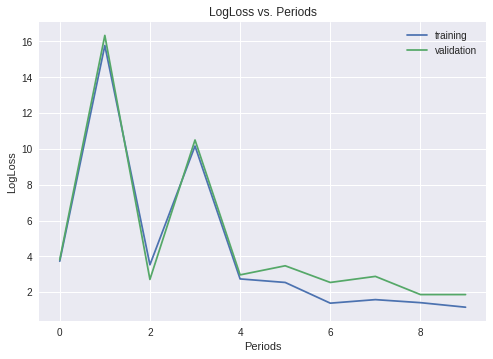

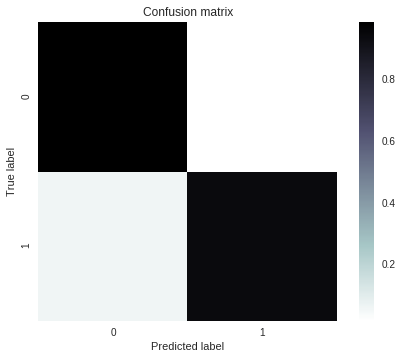

[input: 4096, 4096, 2048, output 2]
0.1
1224
408
1
0.9632352941176471
0
0.9632352941176471
Training model...
LogLoss error (on validation data):
  period 00 : 6.18
  period 01 : 13.80
  period 02 : 4.15
  period 03 : 6.77
  period 04 : 3.47
  period 05 : 2.37
  period 06 : 1.78
  period 07 : 2.45
  period 08 : 1.44
  period 09 : 1.86
Model training finished.
Final accuracy (validation data): 0.92


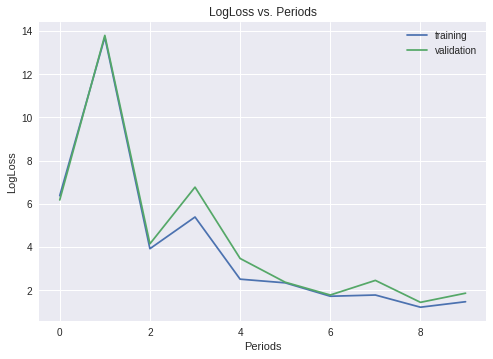

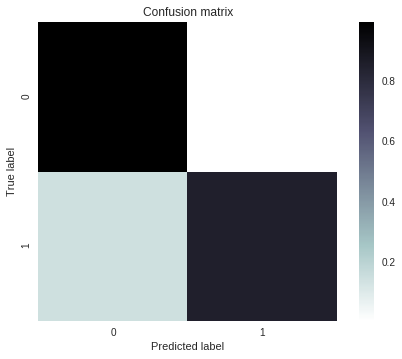

[input: 4096, 4096, 2048, output 2]
0.1
1224
408
1
0.9240196078431373
Training model...
LogLoss error (on validation data):
  period 00 : 3.81
  period 01 : 3.05
  period 02 : 2.12
  period 03 : 3.98
  period 04 : 2.20
  period 05 : 8.55
  period 06 : 1.78
  period 07 : 1.86
  period 08 : 2.20
  period 09 : 1.78
Model training finished.
Final accuracy (validation data): 0.95


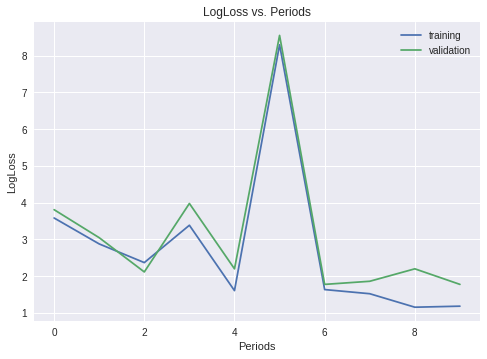

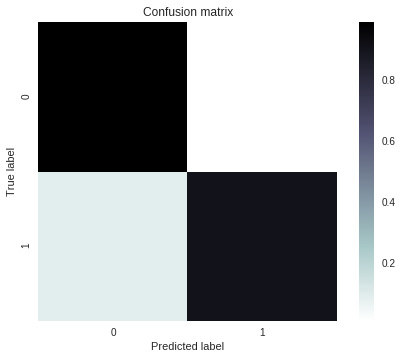

[input: 4096, 4096, 2048, output 2]
0.1
1224
408
1
0.9485294117647058
Training model...
LogLoss error (on validation data):
  period 00 : 4.57
  period 01 : 15.07
  period 02 : 3.72
  period 03 : 2.29
  period 04 : 2.29
  period 05 : 2.54
  period 06 : 2.54
  period 07 : 3.81
  period 08 : 2.37
  period 09 : 3.72
Model training finished.
Final accuracy (validation data): 0.88


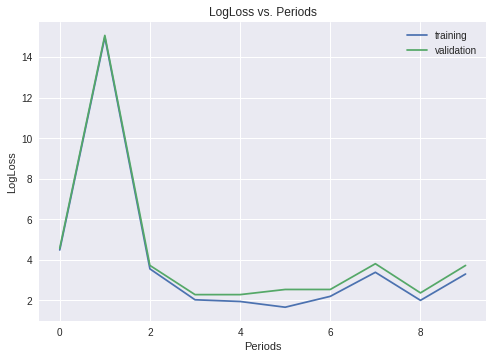

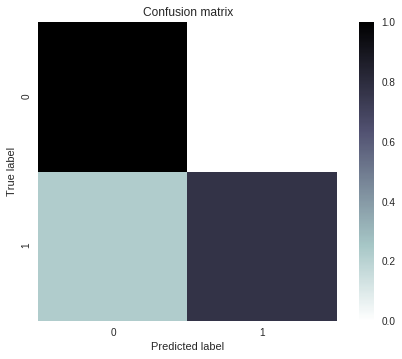

[input: 4096, 4096, 2048, 1024, output 2]
0.1
1224
408
1
0.8848039215686274
0
0.8848039215686274
Training model...
LogLoss error (on validation data):
  period 00 : 2.88
  period 01 : 17.18
  period 02 : 4.83
  period 03 : 2.79
  period 04 : 2.62
  period 05 : 2.45
  period 06 : 2.03
  period 07 : 1.86
  period 08 : 1.52
  period 09 : 1.52
Model training finished.
Final accuracy (validation data): 0.96


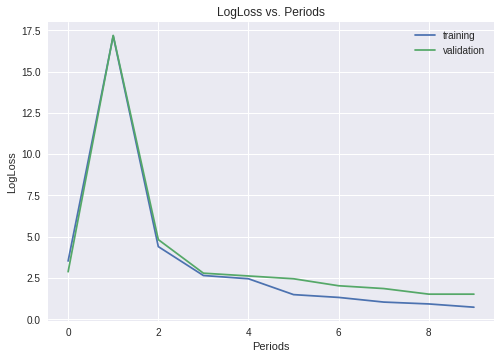

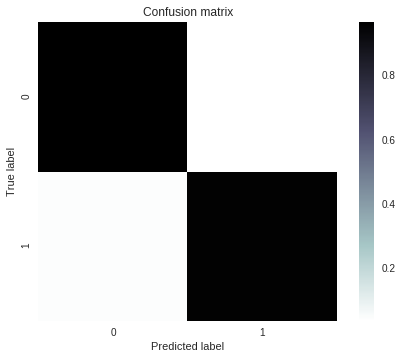

[input: 4096, 4096, 2048, 1024, output 2]
0.1
1224
408
1
0.9607843137254902
0.8848039215686274
0.9607843137254902
Training model...
LogLoss error (on validation data):
  period 00 : 4.74
  period 01 : 3.39
  period 02 : 17.44
  period 03 : 2.12
  period 04 : 1.86
  period 05 : 2.29
  period 06 : 6.35
  period 07 : 8.72
  period 08 : 3.89
  period 09 : 1.61
Model training finished.
Final accuracy (validation data): 0.95


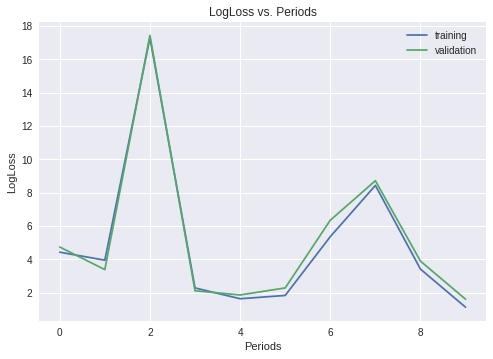

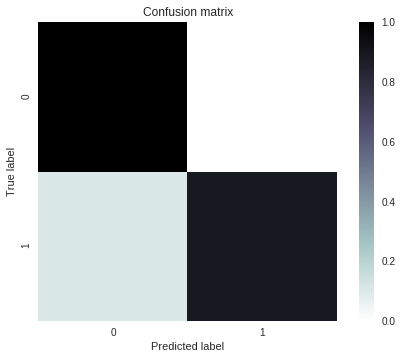

[input: 4096, 4096, 2048, 1024, output 2]
0.1
1224
408
1
0.946078431372549


In [12]:
num_samples = signal_dataframe.shape[0]
learning_rate_steps = [0.1]
data_set_distribution= [[60, 20, 20]]
d = dict()
df = pd.DataFrame(data=d)
models = [[4096, 2048] , [4096, 2048, 1024]]
batch_sizes=[1]
time_string = time.strftime("%Y%m%d-%H%M%S")
name = "test"+time_string+".xlsx"
line=1
with open(name, 'w') as f:
  writer = pd.ExcelWriter(name)
  df.to_excel(writer, sheet_name='Sheet1')
  workbook = writer.book
  worksheet = writer.sheets['Sheet1']
  prepareWorksheet(worksheet)
  for model in models: #number of neurons per layer
    for learning_rate in learning_rate_steps: # learning_rate used for training
      for v in data_set_distribution: # try several dataset_distributions
        for batch_size in batch_sizes:
                last_accuracy=max_accuracy=0
                ckp_best_model=""
                training_set_size = int(num_samples * (v[0]/100))
                validating_set_size = int(num_samples * (v[1]/100))
                test_set_size = int(num_samples * (v[2]/100))
                for x in range(0,3):
                  last_accuracy=train_automated(
                        training_set_size,
                        validating_set_size,
                        test_set_size,
                        learning_rate,
                        training_set_size//batch_size,
                        batch_size,
                        model,
                        worksheet,
                        line = line)
                        #insertIntoWorksheet(worksheet, line, "model", learning_rate, training_set_size,validating_set_size , batch_size , 1, "pic1")
                  line = line + 1
                  if max_accuracy < last_accuracy:
                    max_accuracy = last_accuracy
                    ckpname= str(model)+"-"+time_string + "-" + str(x)
                    os.rename("./models/checkpoint", ckpname)
                    if ckp_best_model != "":
                      os.remove(ckp_best_model)
                    ckp_best_model = ckpname
                  else:
                    os.remove("models/checkpoint")   
                line = line + 1 
  writer.save()
  writer.close()
        
      
    